# Экзогенные переменные

## Импорт модулей

In [155]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

## Данные

In [146]:
gas = pd.read_csv('data/gas.csv', index_col='Date', parse_dates=True)

In [147]:
gas.index.freq = 'D'

In [134]:
gas["const"] = 1

In [135]:
gas.head()

,Consumption,Mean temperature,const
Date,,,
2016-01-01,233.59,5.86,1
2016-01-02,250.99,6.87,1
2016-01-03,242.07,7.13,1
2016-01-04,286.05,7.28,1
2016-01-05,284.71,8.22,1


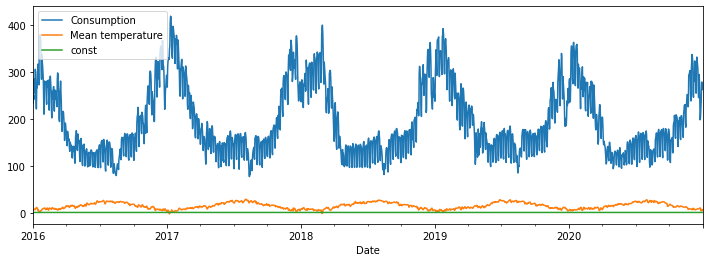

In [138]:
gas.plot(figsize=(12,4))
plt.show()

## Модель

In [123]:
prMean = gas[["Mean temperature", "const"]].groupby([gas.index.month, gas.index.day]).mean()
prMin = gas[["Mean temperature", "const"]].groupby([gas.index.month, gas.index.day]).min()
prMax = gas[["Mean temperature", "const"]].groupby([gas.index.month, gas.index.day]).max()

In [125]:
prMean.drop((2,29), axis=0, inplace=True)
prMin.drop((2,29), axis=0, inplace=True)
prMax.drop((2,29), axis=0, inplace=True)

In [103]:
model = SARIMAX(gas["Consumption"],
                exog=gas[["Mean temperature", "const"]],
                order=(3, 1, 1),
                seasonal_order=(2, 1, 1, 7)).fit()

In [104]:
model.params

Mean temperature     -2.618118
const                -0.000002
ar.L1                -0.724284
ar.L2                -0.108519
ar.L3                -0.126115
ma.L1                 0.825607
ar.S.L7               0.176242
ar.S.L14              0.057199
ma.S.L7              -0.998698
sigma2              141.951773
dtype: float64

## Прогнозные коридоры

In [110]:
start = gas.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=364)
start, end

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'))

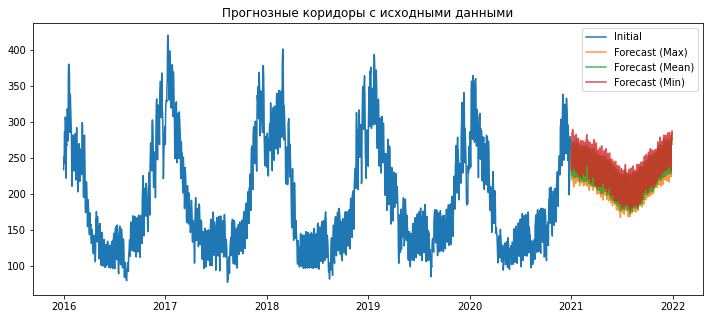

In [145]:
plt.plot(gas["Consumption"])
# model.forecast(365, exog=pr).plot()
plt.plot(model.predict(start=start, end=end, exog=prMax), alpha=0.8)
plt.plot(model.predict(start=start, end=end, exog=prMean), alpha=0.8)
plt.plot(model.predict(start=start, end=end, exog=prMin), alpha=0.8)
plt.legend(["Initial", "Forecast (Max)", "Forecast (Mean)", "Forecast (Min)"])
plt.title("Прогнозные коридоры с исходными данными")
plt.show()

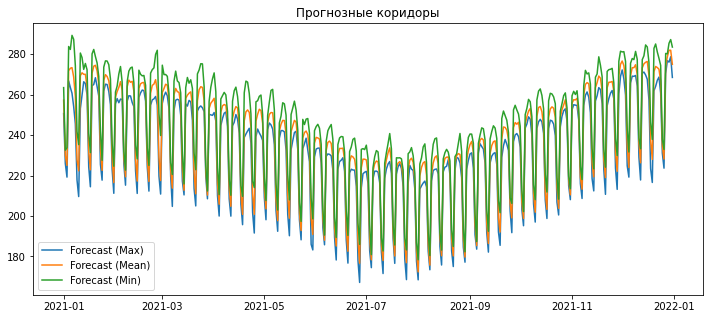

In [140]:
plt.plot(model.predict(start=start, end=end, exog=prMax))
plt.plot(model.predict(start=start, end=end, exog=prMean))
plt.plot(model.predict(start=start, end=end, exog=prMin))
plt.legend(["Forecast (Max)", "Forecast (Mean)", "Forecast (Min)"])
plt.title("Прогнозные коридоры")
plt.show()

## Обычная линейная регрессия

In [194]:
gas = pd.read_csv('data/gas.csv', index_col='Date', parse_dates=True)

In [195]:
gas.index.freq = 'D'

In [196]:
X = gas[["Mean temperature"]]

In [197]:
X = sm.add_constant(X)

In [198]:
y = gas["Consumption"]

In [199]:
model = OLS(y, X).fit()

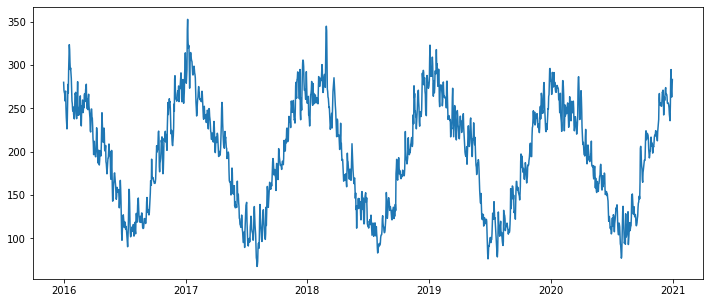

In [200]:
plt.plot(model.fittedvalues)
plt.show()

In [201]:
resid = y - model.fittedvalues

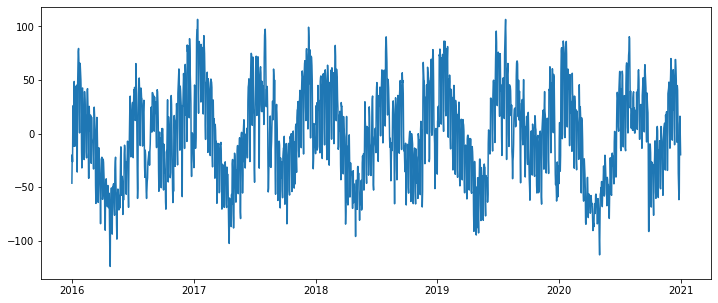

In [202]:
plt.plot(resid)
plt.show()

In [227]:
resModel = SARIMAX( resid,
                    order=(3, 1, 1),
                    seasonal_order=(2, 1, 1,
 7)).fit()

/home/egor/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [228]:
resPred = resModel.predict(start=start, end=end).values

In [238]:
prMean = X.groupby([gas.index.month, gas.index.day]).mean()
prMin = X.groupby([gas.index.month, gas.index.day]).min()
prMax = X.groupby([gas.index.month, gas.index.day]).max()

In [239]:
for name in ["prMean", "prMax", "prMin"]:
    eval(f"{name}.drop((2,29), axis=0, inplace=True)")

In [240]:
predMean = model.predict(prMean.values)
predMin = model.predict(prMin.values)
predMax = model.predict(prMax.values)

In [241]:
dfPred = pd.Series(resPred + predMean, index=pd.date_range(start,end))
dfPredMin = pd.Series(resPred + predMin, index=pd.date_range(start,end))
dfPredMax = pd.Series(resPred + predMax, index=pd.date_range(start,end))

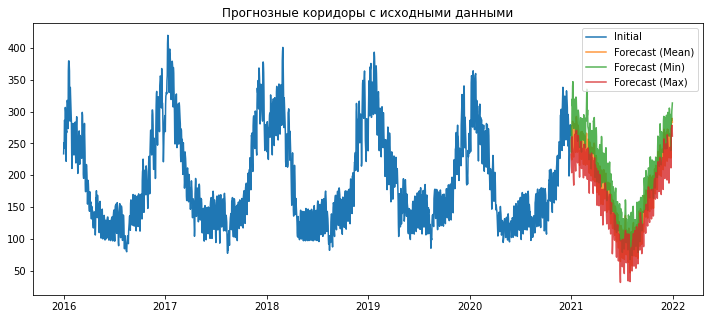

In [243]:
plt.plot(gas["Consumption"])
plt.plot(dfPred, alpha=0.8)
plt.plot(dfPredMin, alpha=0.8)
plt.plot(dfPredMax, alpha=0.8)
plt.legend(["Initial", "Forecast (Mean)", "Forecast (Min)", "Forecast (Max)"])
plt.title("Прогнозные коридоры с исходными данными")
plt.show()